# Model Performance Evaluation

## Packages

In [1]:
!pip install -U scikit-learn==1.0.2 --quiet
!pip install sagemaker-experiments --quiet
!pip install -U seaborn --quiet
!pip install lightgbm --quiet
!pip install -U shap --quiet


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import pickle
import tarfile
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import sagemaker

from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)

from smexperiments import experiment, tracker, trial
from sagemaker.s3 import S3Downloader

## Configuration

`test_data_s3_uri` is a s3 uri link to the data you want to use for evaluating the model. Make sure it contains the keys, features and the target variable. Note that the features have to be encoded already.

`model_data` is the s3 uri of the model you want to evaluate.

In [3]:
test_data_s3_uri = "s3://nike--451746848004--qa--eu-west-1/knnights/qa/shapeshifter/data/processed/2023-02-21T18:52:24.661Z/test/data.csv"
model_data = "s3://nike--451746848004--qa--eu-west-1/knnights/qa/shapeshifter/models/repacked_model/LightGBM/pipelines-e1iubqvxksmq-RegisterApproved-Rep-591AvmKL19/output/model.tar.gz"

## Get model

In [4]:
best_model = sagemaker.model.Model(
    model_data=model_data,
    image_uri="763104351884.dkr.ecr.eu-west-1.amazonaws.com/pytorch-inference:1.9.0-cpu-py38",
)


S3Downloader.download(best_model.model_data, "lightgbm")

t = tarfile.open("lightgbm/model.tar.gz")
t.extractall("lightgbm")

with open("lightgbm/model.pkl", "rb") as f:
    model = pickle.load(f)

## Get data

In [5]:
keys = [
    "SALES_ORDER_HEADER_NUMBER",
    "SALES_ORDER_ITEM_NUMBER",
    "SALES_ORDER_SCHEDULE_LINE_NUMBER",
]

features = [
    "CHANNEL_CLASS",
    "DISTRIBUTION_CHANNEL",
    "DIVISION_CODE",
    "SIZE_CODE",
    "SILHOUETTE_SHORT",
    "SALES_ORDER_ITEM_VAS_INDICATOR",
    "VAS_CODE_ZP1",
    "VAS_CODE_SK",
    "VAS_CODE_C20",
    "VAS_CODE_C4X",
    "VAS_CODE_PR",
    "VAS_CODE_C90",
    "VAS_CODE_STD",
    "VAS_CODE_CL1",
    "VAS_CODE_LBC",
    "VAS_CODE_SM",
    "VAS_CODE_CU",
    "VAS_CODE_ES",
    "VAS_CODE_C40",
    "VAS_CODE_CTU",
    "VAS_CODE_CLX",
    "VAS_CODE_SZU",
    "VAS_CODE_REST",
    "VAS_CODE_NONE",
    "COUNTRY_CODE",
    "CUSTOMER_ACCOUNT_GROUP_CODE",
    "SALES_ORDER_TYPE",
    "FULL_CASE_QUANTITY",
    "SOSL_TOTAL_QTY",
    "SOI_TOTAL_QUANTITY",
    "SOH_TOTAL_QUANTITY",
]

target = "NBR_CARTONS_RATIO"

S3Downloader.download(test_data_s3_uri, "test_data")

In [6]:
df_test = pd.read_csv("test_data/data.csv", names=keys + [target] + features)
df_test

,SALES_ORDER_HEADER_NUMBER,SALES_ORDER_ITEM_NUMBER,SALES_ORDER_SCHEDULE_LINE_NUMBER,NBR_CARTONS_RATIO,CHANNEL_CLASS,DISTRIBUTION_CHANNEL,DIVISION_CODE,SIZE_CODE,SILHOUETTE_SHORT,SALES_ORDER_ITEM_VAS_INDICATOR,...,VAS_CODE_SZU,VAS_CODE_REST,VAS_CODE_NONE,COUNTRY_CODE,CUSTOMER_ACCOUNT_GROUP_CODE,SALES_ORDER_TYPE,FULL_CASE_QUANTITY,SOSL_TOTAL_QTY,SOI_TOTAL_QUANTITY,SOH_TOTAL_QUANTITY
0,7406784532,150,4,0.461538,15,0,0,314,55,0,...,0,0,1,22,1,1,24.0,6.0,19.0,680.0
1,7291865444,10,1,14.159663,15,0,1,288,56,1,...,0,0,0,14,1,1,12.0,14.0,900.0,2700.0
2,7353708281,10,1,2.000000,2,0,2,189,77,1,...,0,0,1,18,1,1,24.0,11.0,14.0,14.0
3,7425250282,10,1,0.222222,9,0,0,352,84,1,...,0,0,1,10,2,0,60.0,2.0,2.0,9.0
4,7374084155,70,1,0.142857,9,0,2,314,0,1,...,0,0,1,43,2,0,96.0,6.0,6.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10523942,7357043666,150,5,0.200000,2,0,1,294,1,0,...,0,0,1,17,1,8,9.0,2.0,18.0,162.0
10523943,7313504037,150,4,0.250000,15,0,0,341,54,1,...,0,0,1,24,2,8,60.0,1.0,8.0,88.0
10523944,7372978822,100,1,0.062500,9,0,0,352,55,1,...,0,0,1,44,2,4,18.0,1.0,1.0,30.0
10523945,7387766423,110,3,0.321429,10,0,0,301,28,1,...,0,0,1,17,2,7,36.0,9.0,22.0,143.0


## Create predictions

In [7]:
df_test["pred_lightgbm"] = np.exp(list(model.predict(df_test[features])))

## Calculate metrics

In [8]:
def get_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return pd.Series({"mse": mse, "r2": r2, "mae": mae, "mape": mape})

### Overall

In [9]:
get_metrics(df_test["NBR_CARTONS_RATIO"], df_test["pred_lightgbm"])

mse     19.108368
r2       0.410521
mae      0.331880
mape     0.446298
dtype: float64

#### Grouped on Sales Order Header level

In [10]:
df_test_grouped = df_test.groupby("SALES_ORDER_HEADER_NUMBER", as_index=False).agg(
    {"pred_lightgbm": "sum", "NBR_CARTONS_RATIO": "sum"}
)

get_metrics(df_test_grouped["NBR_CARTONS_RATIO"], df_test_grouped["pred_lightgbm"])

mse     2262.182587
r2         0.672151
mae        2.292456
mape       0.242135
dtype: float64

## Actuals vs predictions

In [11]:
df_test["diff"] = df_test["NBR_CARTONS_RATIO"] - df_test["pred_lightgbm"]
df_test["diff_prec"] = df_test["diff"] / df_test["NBR_CARTONS_RATIO"]

df_test_grouped["diff"] = (
    df_test_grouped["NBR_CARTONS_RATIO"] - df_test_grouped["pred_lightgbm"]
)

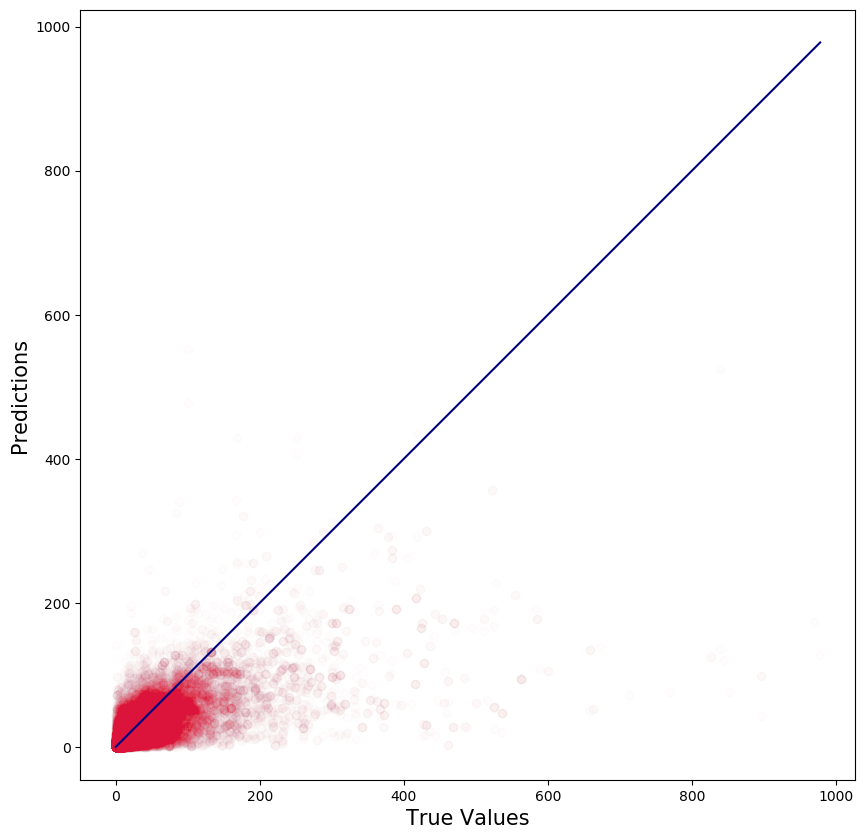

In [12]:
true_value = df_test.query("NBR_CARTONS_RATIO < 1000")["NBR_CARTONS_RATIO"]
predicted_value = df_test.query("NBR_CARTONS_RATIO < 1000")["pred_lightgbm"]

plt.figure(figsize=(10, 10))
plt.scatter(true_value, predicted_value, c="crimson", alpha=0.01)

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], "navy")
plt.xlabel("True Values", fontsize=15)
plt.ylabel("Predictions", fontsize=15)
plt.axis("equal")
plt.show()

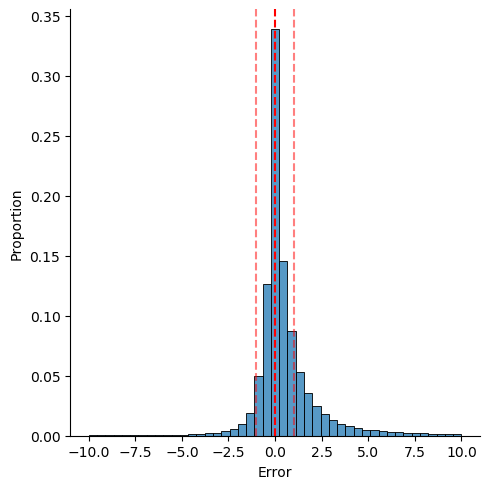

In [13]:
plot = (
    sns.displot(
        df_test_grouped.query("diff > -10 & diff < 10")["diff"].values,
        bins=45,
        stat="probability",
    )
    .set_xlabels("Error")
    .set_ylabels("Proportion")
    .refline(x=0, color="red")
    .refline(x=1, color="red", alpha=0.5)
    .refline(x=-1, color="red", alpha=0.5)
)
plt.show()

## Shap

#### This will run for a **long time**, so skip it if you want to be fast or use a sample of the test data.

In [14]:
%%time
shap_data = df_test.sample(frac=0.1)
shap_values = shap.TreeExplainer(model).shap_values(shap_data[features])

CPU times: user 3h 9min 47s, sys: 5.31 s, total: 3h 9min 53s
Wall time: 23min 56s


### Summary plots per features
Below plots give an indication of the impact to the model per value of a feature. It also shows the interaction with the feature that has the highest interaction.

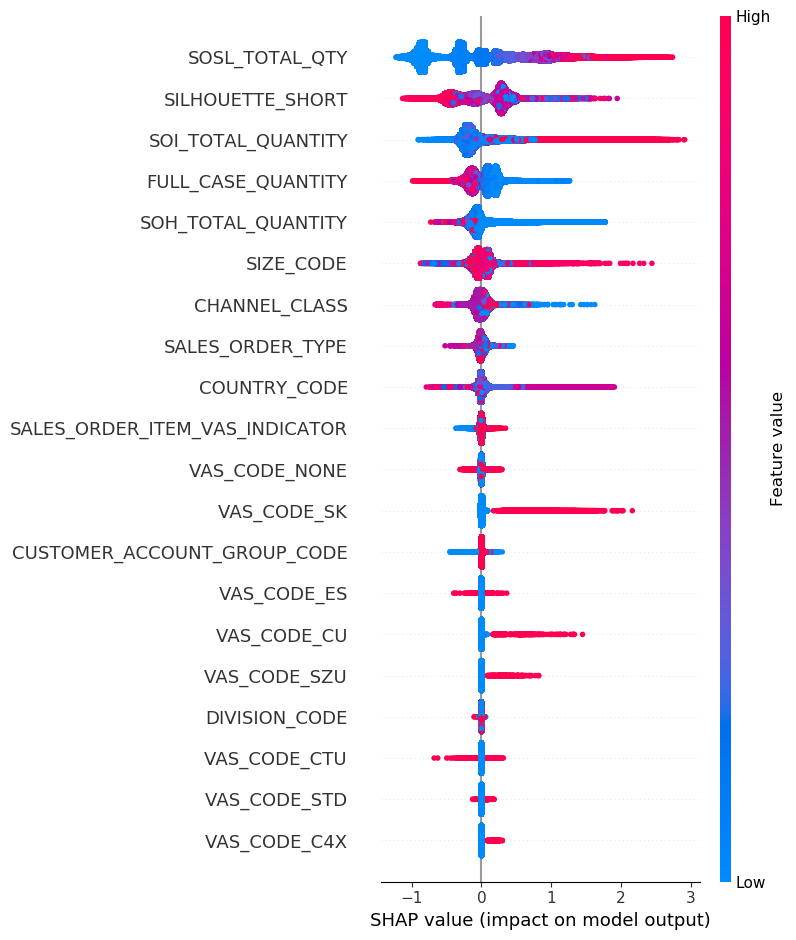

In [15]:
shap.summary_plot(shap_values, shap_data[features])

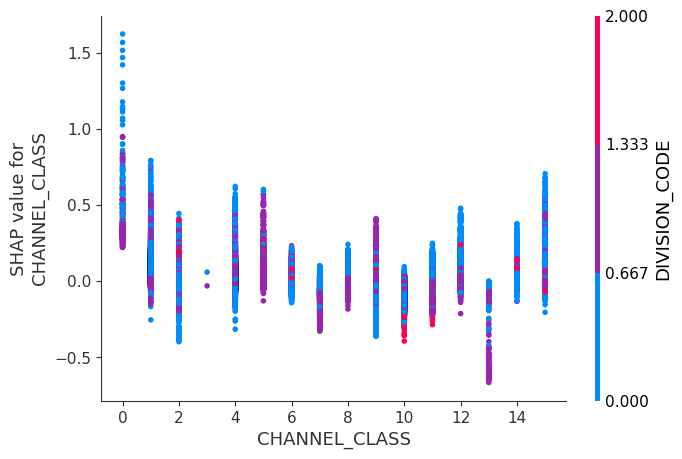

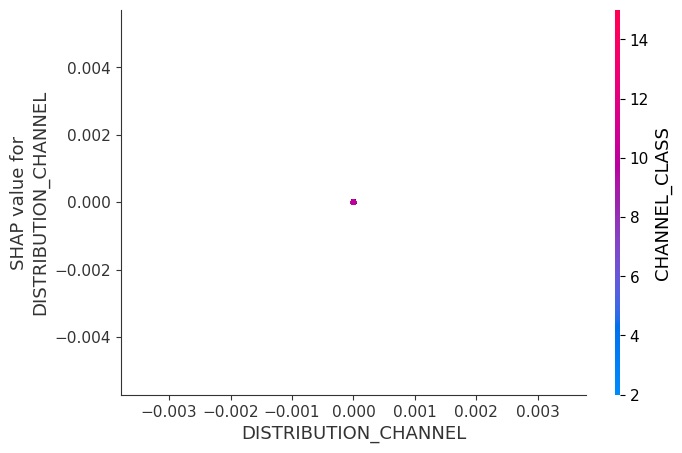

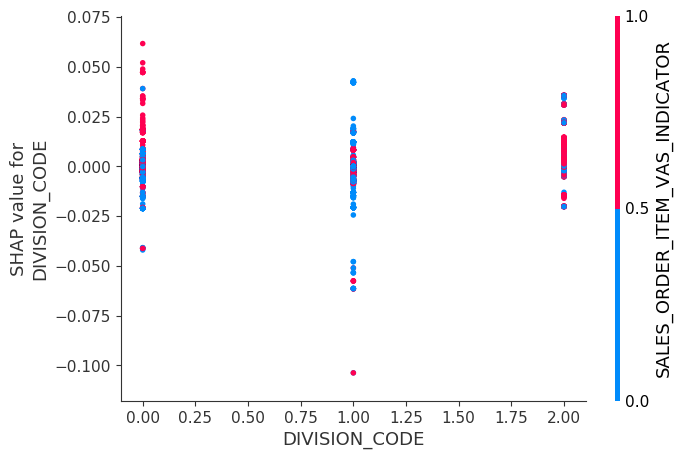

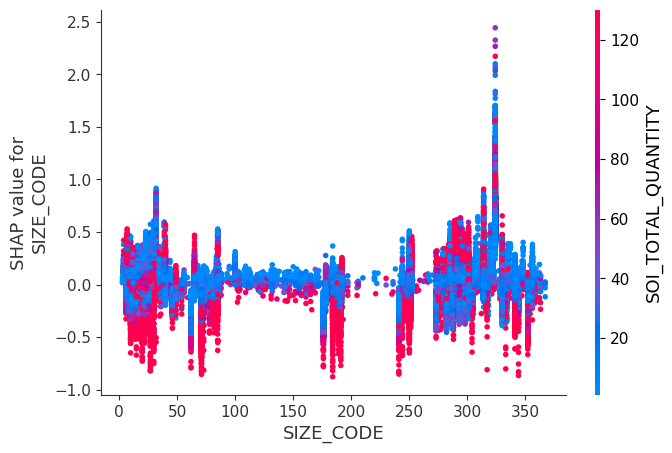

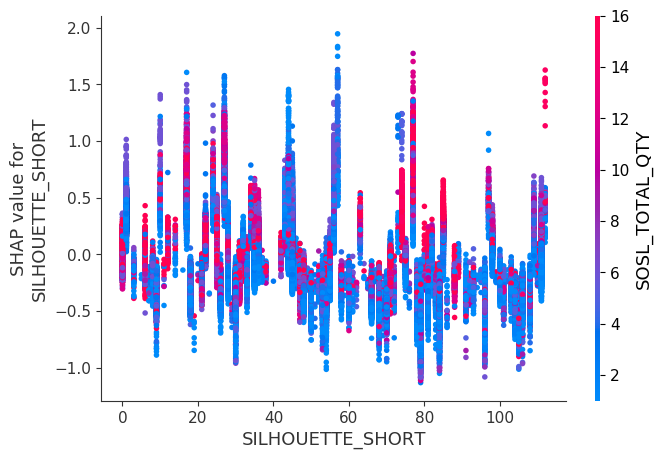

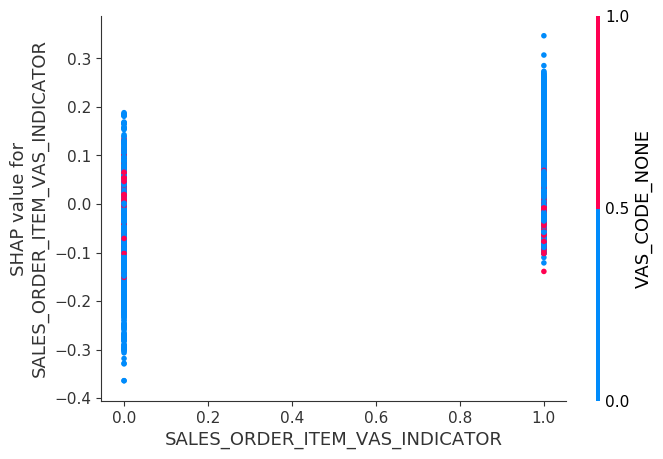

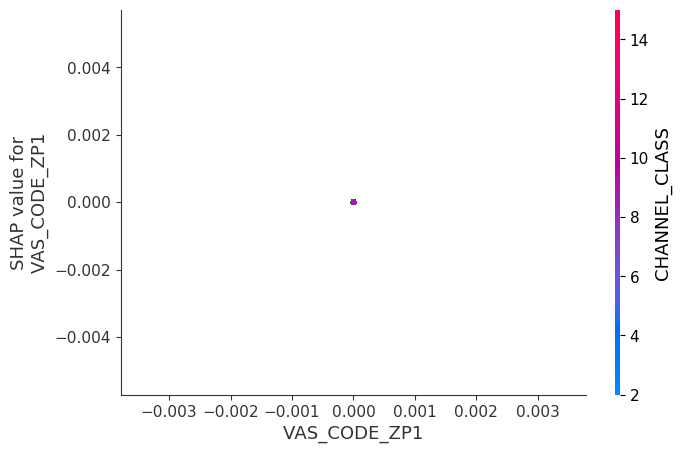

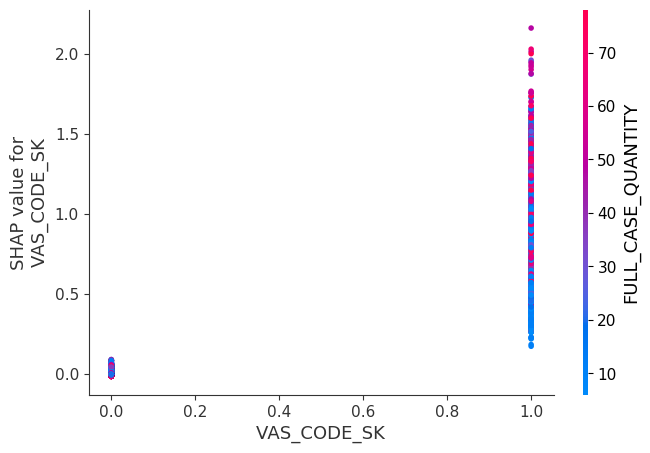

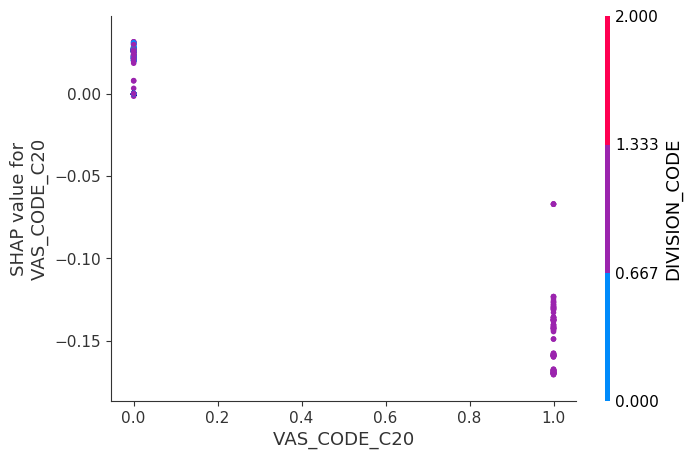

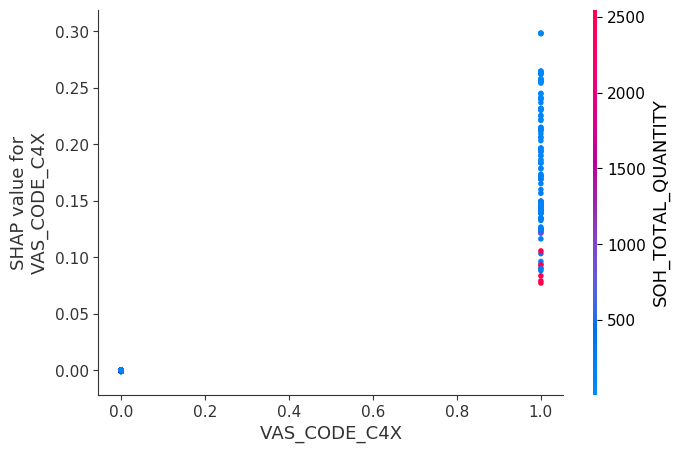

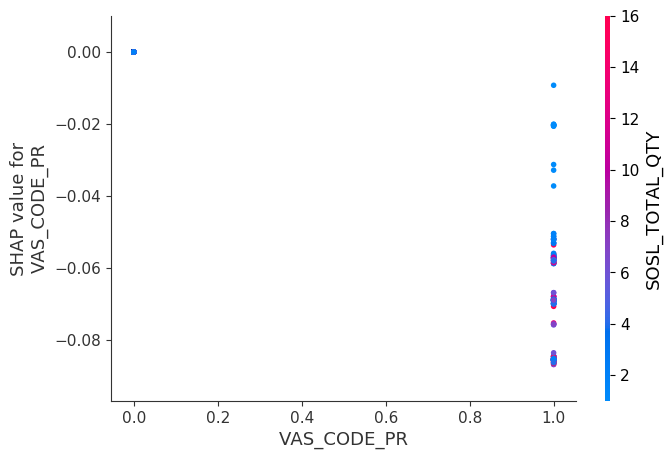

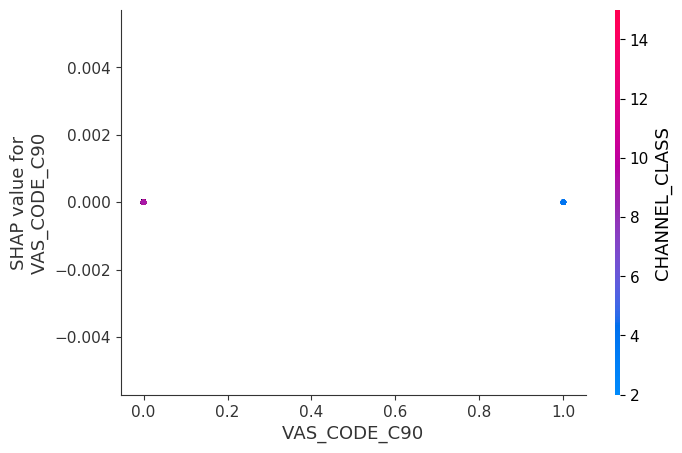

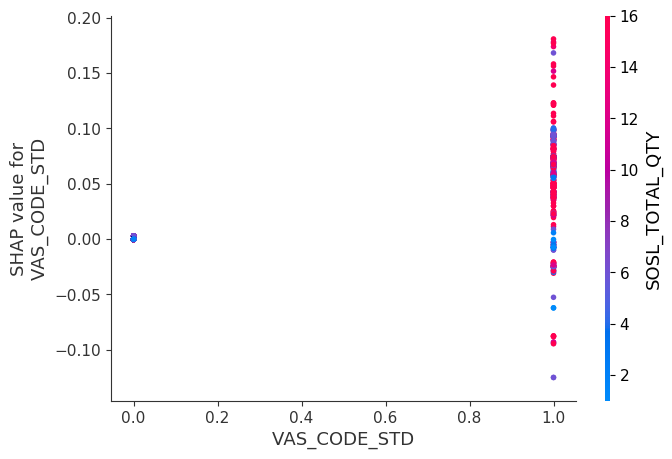

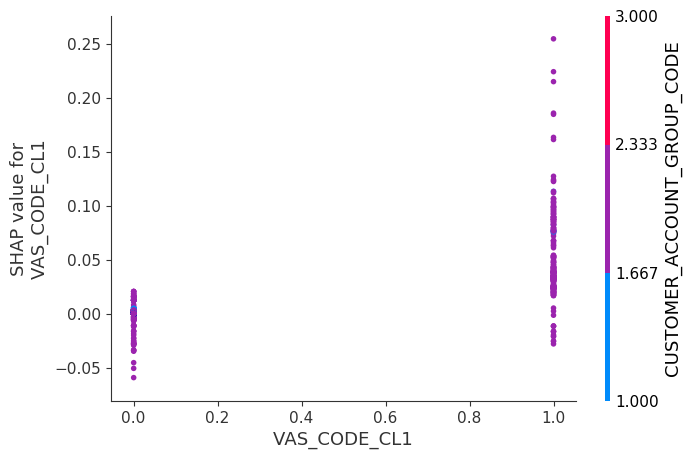

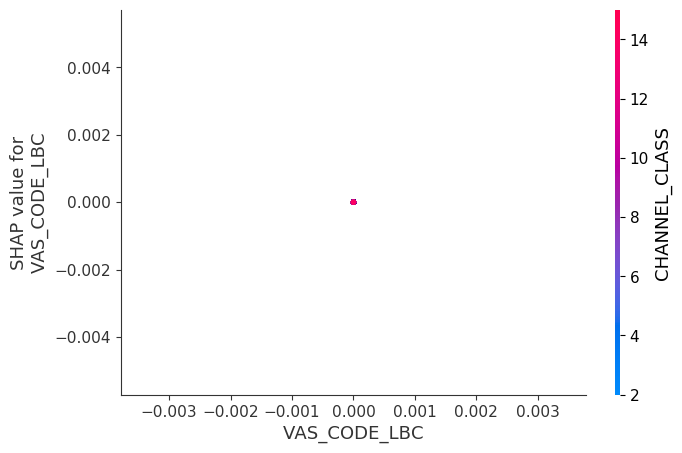

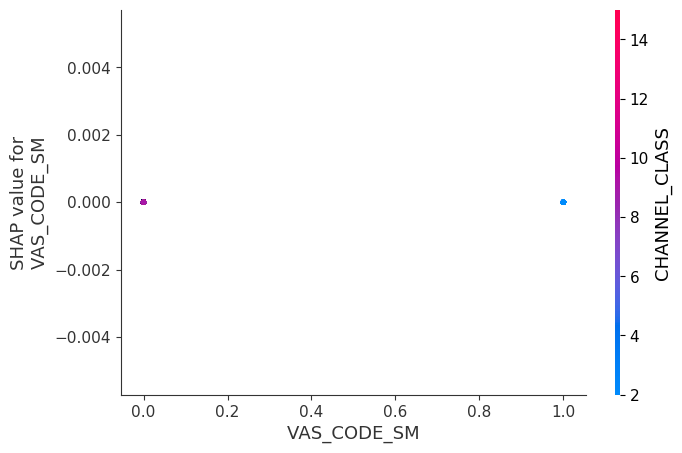

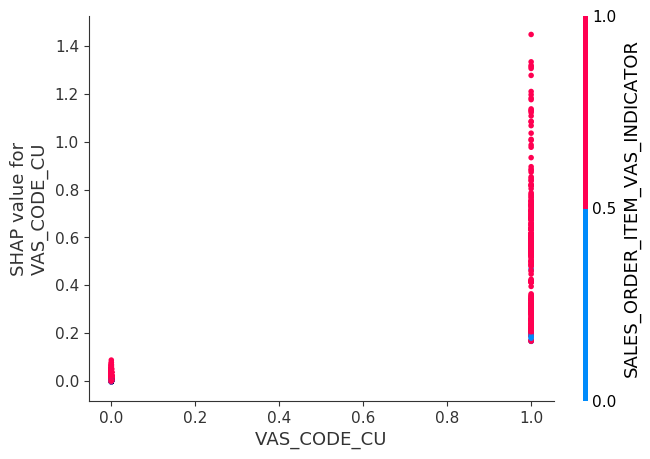

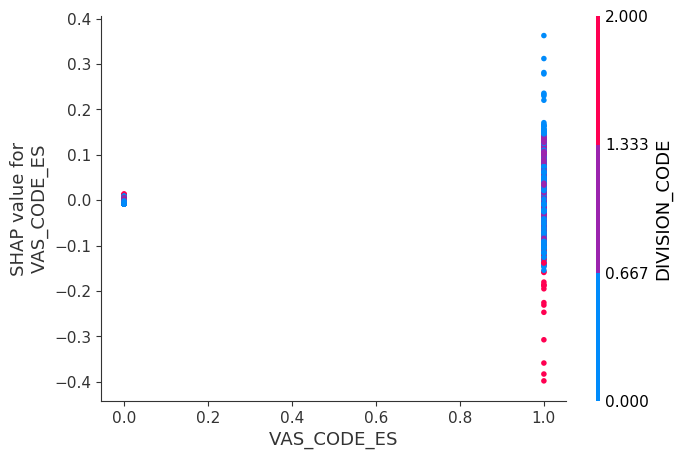

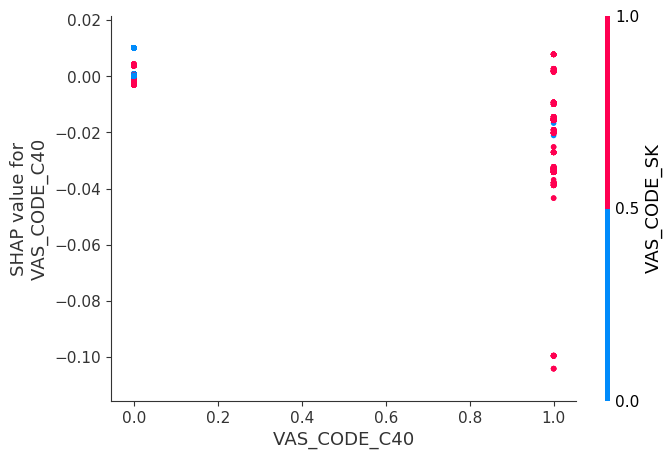

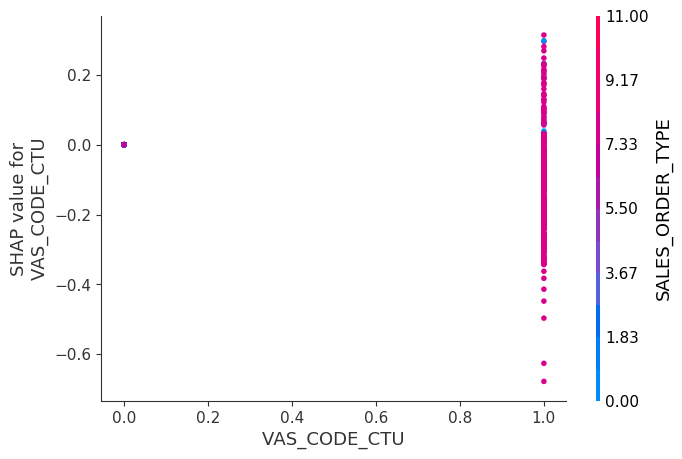

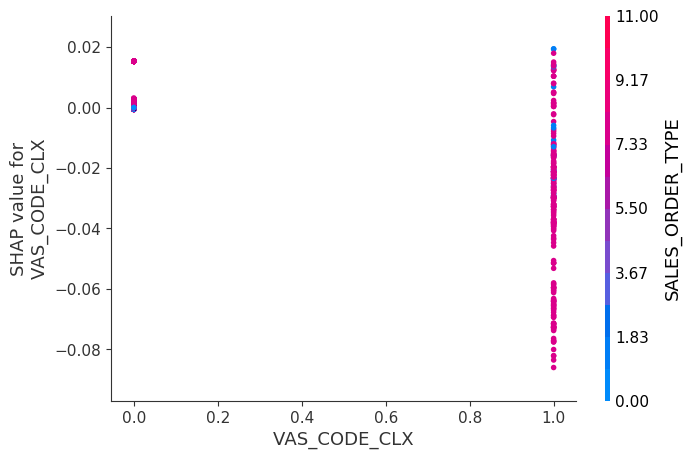

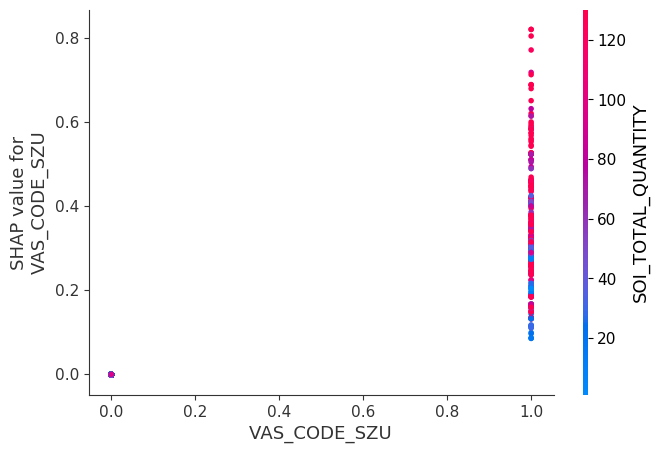

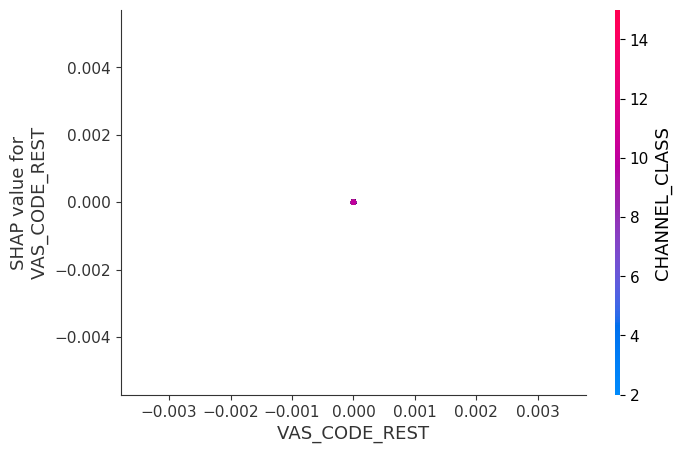

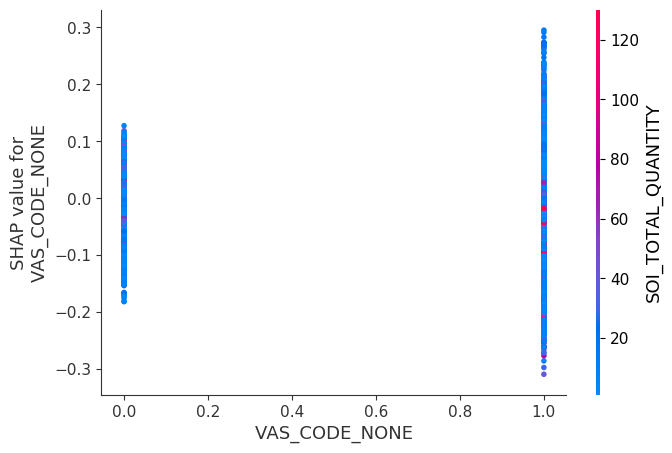

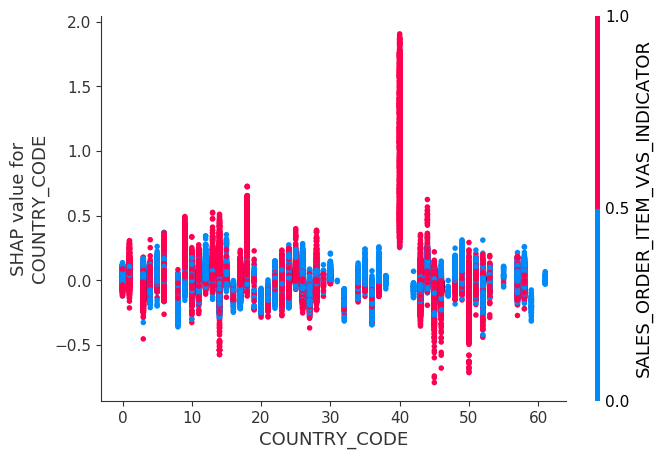

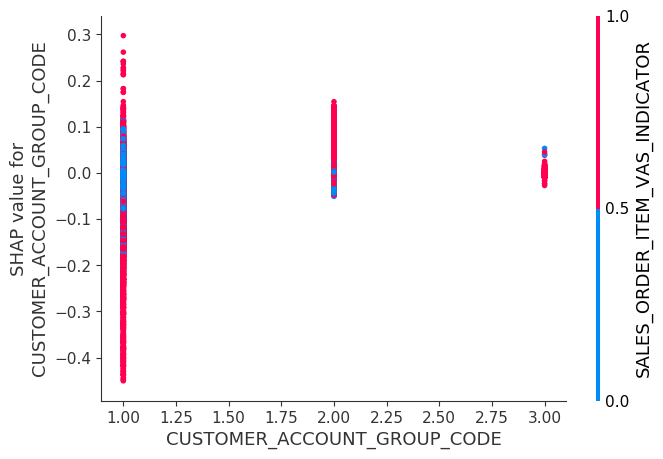

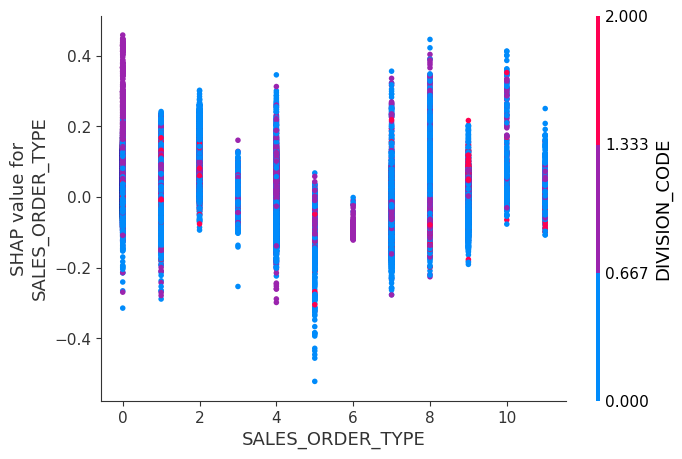

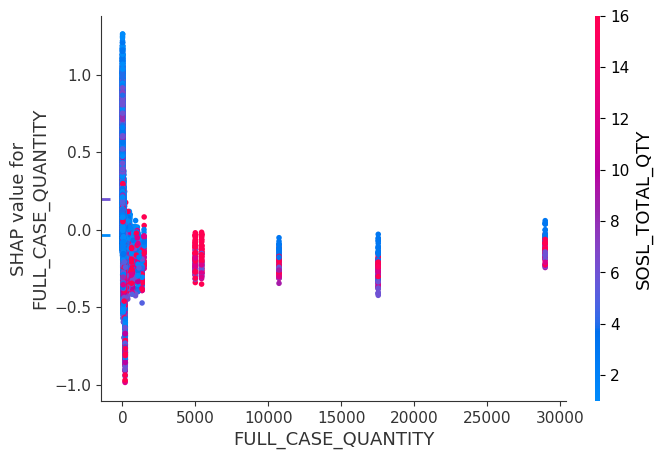

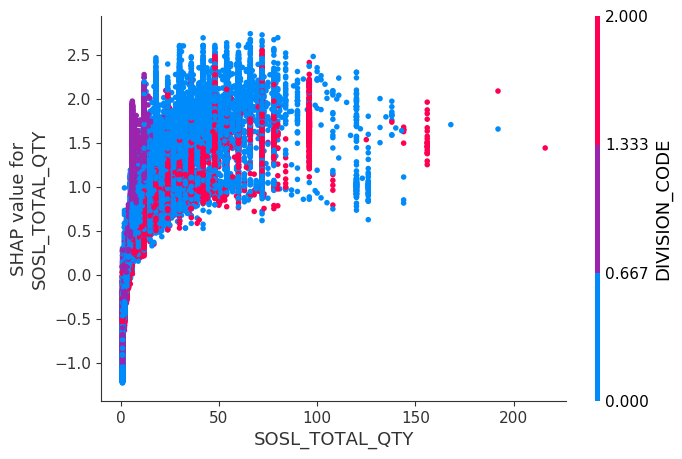

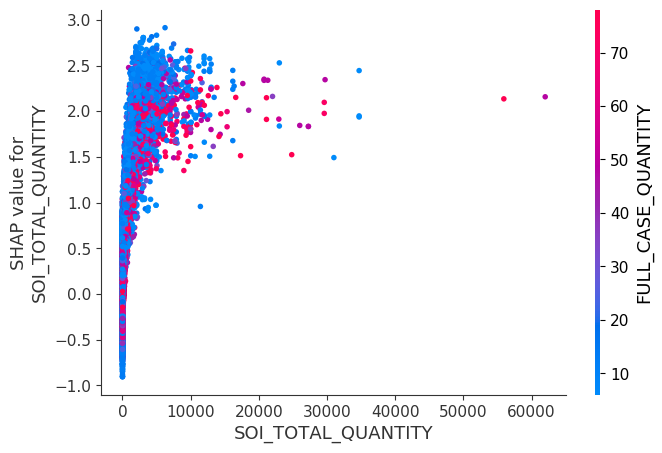

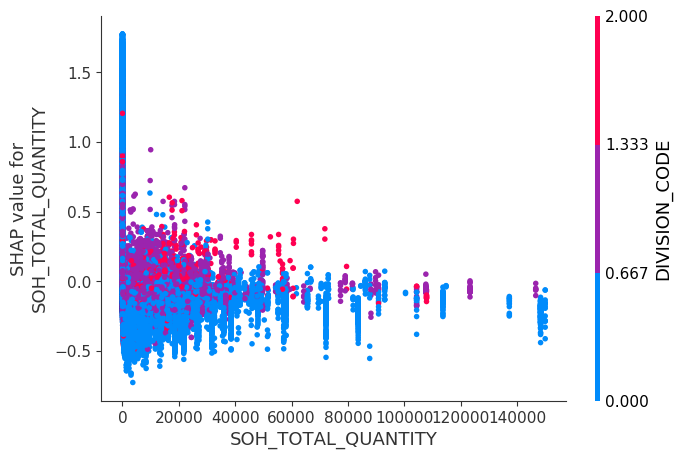

In [16]:
for feature in features:
    shap.dependence_plot(feature, shap_values, shap_data[features])

## Local explanations
Local explanations give the ability to explain how the model came to a specific predition by indicating how much each feature attributed to the final prediction. This can help in identifying why specific predictions are off or which features don't behave as expected.

In [17]:
shap.initjs()

Define `shap_local_data` the way you need it by filtering for the wanted records (e.g. values of which the error is very big). It can contain one or more records, in the waterfall plot you can than select the record you want to visualize.

In [ ]:
# compute SHAP values
shap_local_data = df_test.query("diff > 1000").reset_index(drop=True).loc[0:0]
explainer = shap.Explainer(model)
shap_values = explainer(shap_local_data[features])

shap.plots.waterfall(shap_values[0])